**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Data Preprocessing](#2-bullet)
3. [RSI Computing](#3-bullet)
4. [Trainding Agent](#4-bullet)


## 1. [Libraries and settings](#1-bullet)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

## 2. [Data Preprocessing](#2-bullet)

In [2]:
df = pd.read_csv('C:/Users/Admin/Desktop/Capstone-Project-Machine Learning/Dataset/construction/PTC.csv', sep='\t', index_col='Unnamed: 0')
df.head()

,Open,High,Low,Close,Volume,TradingDate,Code
0,17146.0,17146.0,15432.0,15432.0,5100,2006-12-25,PTC
1,13889.0,14444.0,13889.0,14444.0,7200,2006-12-26,PTC
2,17043.0,17043.0,15555.0,15555.0,5000,2006-12-27,PTC
3,16232.0,17077.0,16232.0,15555.0,9700,2006-12-28,PTC
4,15747.0,15747.0,14487.0,15432.0,11500,2006-12-29,PTC


In [3]:
df['TraingDate'] = pd.to_datetime(df['TradingDate'], format='%Y/%m/%d')
new_dataset = df[['TradingDate','Volume']]
new_dataset.index = new_dataset['TradingDate']

## 3. [RSI Computing](#3-bullet)

In [4]:
#calculate the changes
change = df['Close'].diff()
change.dropna(inplace=True)
change.head()


1    -988.0
2    1111.0
3       0.0
4    -123.0
5       0.0
Name: Close, dtype: float64

In [5]:
#make 2 copy of changes
change_up = change.copy()
change_down = change.copy()

In [6]:
#denote positive and negative change
change_up[change_up<0] = 0
change_down[change_down>0] = 0
change.equals(change_up+change_down)
avg_up = change_up.rolling(14).mean()
avg_down = change_down.rolling(14).mean().abs()

#calculate RSI
rsi = 100 * avg_up / (avg_up + avg_down)
rsi.head(20)
print(type(rsi))
print(len(rsi))

<class 'pandas.core.series.Series'>
4098


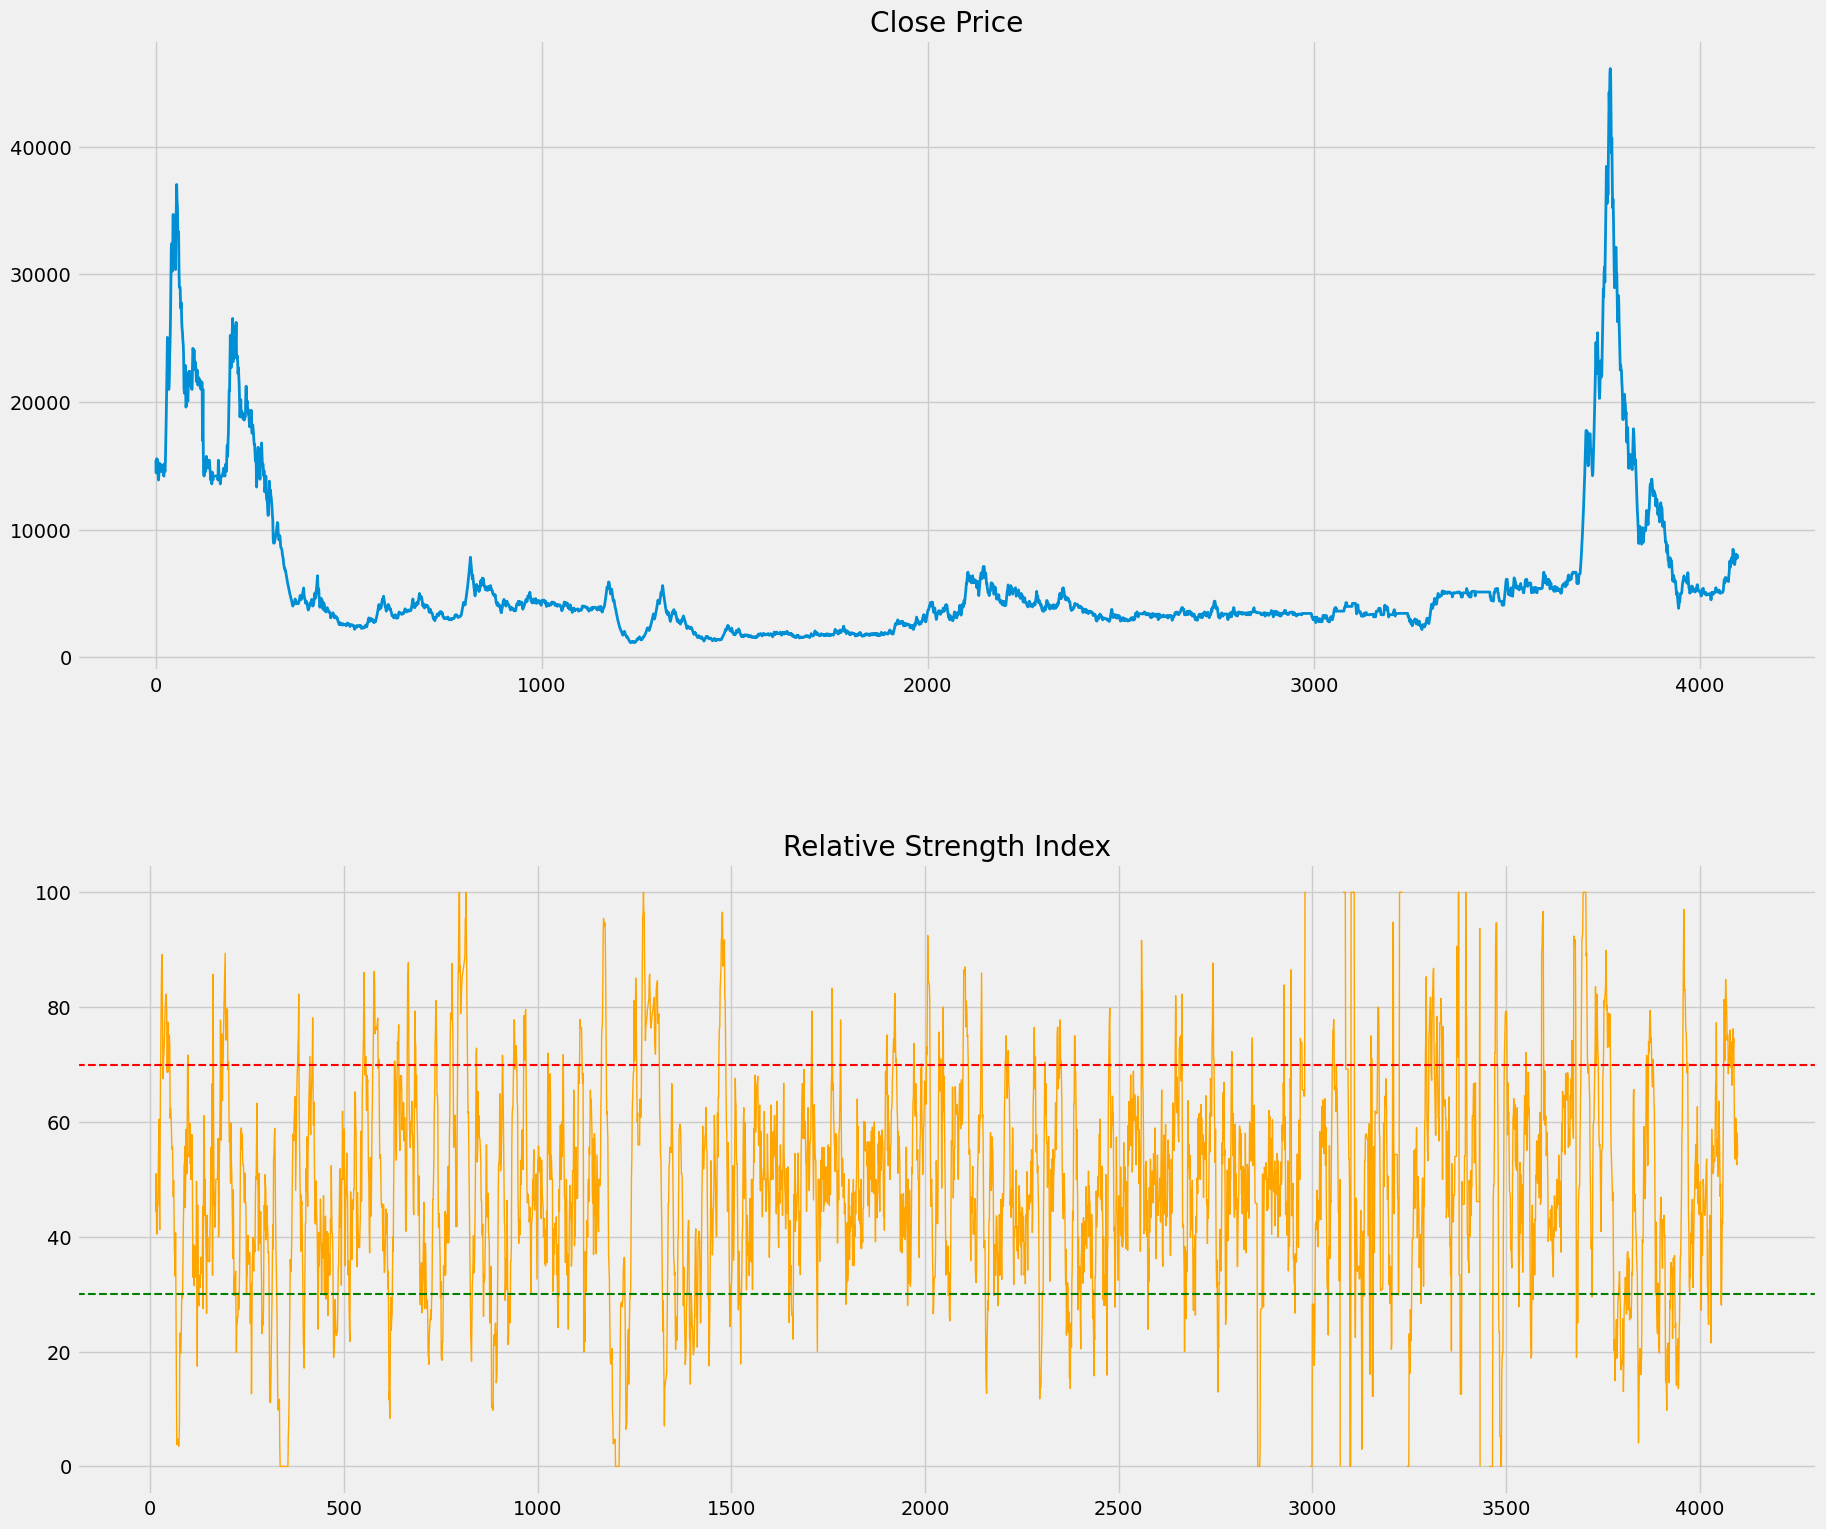

In [7]:
#plot the graph
plt.style.use('fivethirtyeight')

plt.rcParams['figure.figsize'] = (20, 20)

ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)


ax1.plot(df['Close'], linewidth=2)
ax1.set_title('Close Price')

ax2.set_title('Relative Strength Index')
ax2.plot(rsi, color='orange', linewidth=1)

ax2.axhline(30, linestyle='--', linewidth=1.5, color='green')
ax2.axhline(70, linestyle='--', linewidth=1.5, color='red')

## 4. [Trading Agent](#4-bullet)

In [8]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,15432.0,NaN,NaN
1,0.0,14444.0,NaN,NaN
2,0.0,15555.0,NaN,NaN
3,0.0,15555.0,NaN,NaN
4,0.0,15432.0,NaN,NaN
...,...,...,...,...
4094,0.0,8080.0,46115.0,3840.0
4095,0.0,7720.0,46115.0,3840.0
4096,0.0,8000.0,46115.0,3840.0
4097,0.0,8000.0,46115.0,3840.0


In [9]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [10]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 438: buy 1 units at price 3611.000000, total balance 6389.000000
day 442: buy 1 units at price 3549.000000, total balance 2840.000000
day 450: total balances 2840.000000, not enough money to buy a unit price 3488.000000
day 451: total balances 2840.000000, not enough money to buy a unit price 3457.000000
day 453: total balances 2840.000000, not enough money to buy a unit price 3086.000000
day 471: total balances 2840.000000, not enough money to buy a unit price 2932.000000
day 472: buy 1 units at price 2809.000000, total balance 31.000000
day 473: total balances 31.000000, not enough money to buy a unit price 2778.000000
day 474: total balances 31.000000, not enough money to buy a unit price 2654.000000
day 475: total balances 31.000000, not enough money to buy a unit price 2562.000000
day 482: total balances 31.000000, not enough money to buy a unit price 2531.000000
day 493: total balances 31.000000, not enough money to buy a unit price 2469.000000
day 503: total balances 31.0000

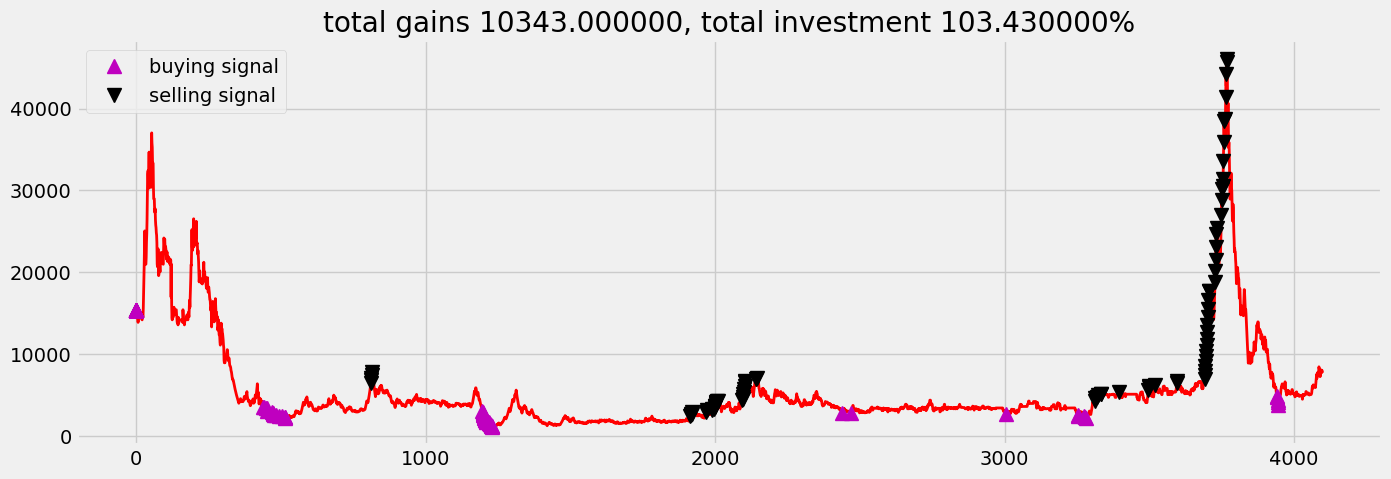

In [11]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()